In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth



In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)
    

In [3]:
setup_tensorflow()

In [4]:

#load the image arrays 


blends = np.load("central_blends.npy")
components = np.load("central_components.npy")
     


In [5]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)
train_components = np.concatenate((a, b, c, d), axis = 1)




In [6]:
blends.shape, train_blends.shape, test_blends.shape

((300, 64, 64), (240, 64, 64), (60, 64, 64))

In [7]:
components.shape, train_components.shape, test_components.shape

((2, 300, 64, 64), (2, 240, 64, 64), (2, 60, 64, 64))

In [8]:

#Normalise the data

#Blends

train_blends_max = np.amax(train_blends)
train_blends_min = np.amin(train_blends)

train_blends = (train_blends - train_blends_min) / (train_blends_max - train_blends_min) 

test_blends_max = np.amax(test_blends)
test_blends_min = np.amin(test_blends)

test_blends = (test_blends - test_blends_min) / (test_blends_max - test_blends_min) 

#Components

train_components_max = np.amax(train_components) 
train_components_min = np.amin(train_components)

train_components = (train_components - train_components_min) / (train_components_max - train_components_min) 

test_components_max = np.amax(test_components) 
test_components_min = np.amin(test_components)

test_components = (test_components - test_components_min) / (test_components_max - test_components_min) 



In [9]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [10]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [11]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [12]:
batch_size = 32
latent_dimensions = 32
beta = 0.1

In [13]:
blends.shape, components.shape

((300, 64, 64), (2, 300, 64, 64))

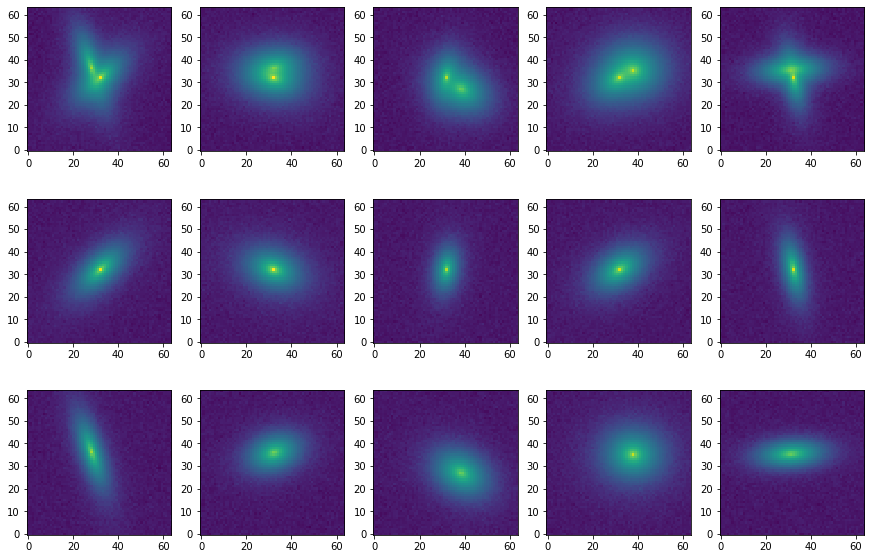

In [14]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)

In [15]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu', strides = 2, padding='same')(x)
    x=Conv2D(64,3,activation='relu', strides = 2, padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [16]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu', strides = 2 ,padding='same')(x)
    x=Conv2DTranspose(32,3,activation='relu', strides = 2 ,padding='same')(x)
    return x

In [17]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [18]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])


In [19]:
# decoder

input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [20]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [21]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 model (Functional)          (None, 32)                281024    
                                                                 
 model_1 (Functional)        (None, 64, 64, 1)         190849    
                                                                 
Total params: 471,873
Trainable params: 471,873
Non-trainable params: 0
_________________________________________________________________


In [22]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam())


In [23]:
blends.shape, components.shape 

((300, 64, 64), (2, 300, 64, 64))

In [24]:

train_together = [train_blends, train_components[0]]

#need an array which has the blends and both components for later use of calculating metrics - this will be using the test set 

metrics_together = [test_blends, test_components[0], test_components[1]]



In [25]:
history1=vae.fit(train_together[1],verbose=1,epochs=1,batch_size=batch_size,validation_split=0.2)

7/7 [==============================] - 2s 184ms/step - loss: 46.7635 - mse_loss: 46.7631 - kl_loss: 3.8402e-04 - val_loss: 30.3680 - val_mse_loss: 30.3672 - val_kl_loss: 7.7753e-04


In [26]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

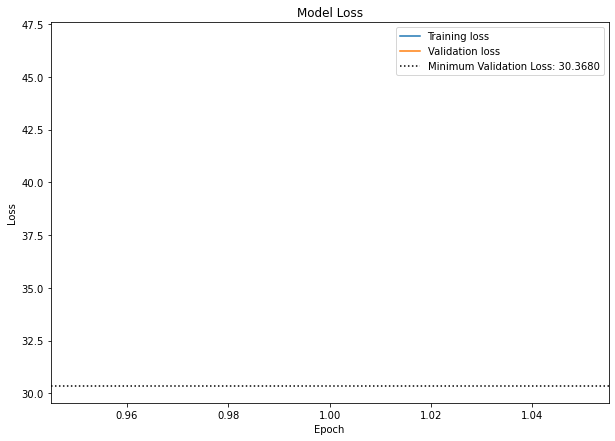

In [27]:
histplot(history1)

In [28]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs), size=n, replace=False)
    input_img = inputs[idx]
    comp1 = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Component')
        ax[1, i].imshow(output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Output Component')
        ax[2, i].imshow(comp1[i] - output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[2, i].set_title('Output Difference')
        plt.tight_layout()
    return idx

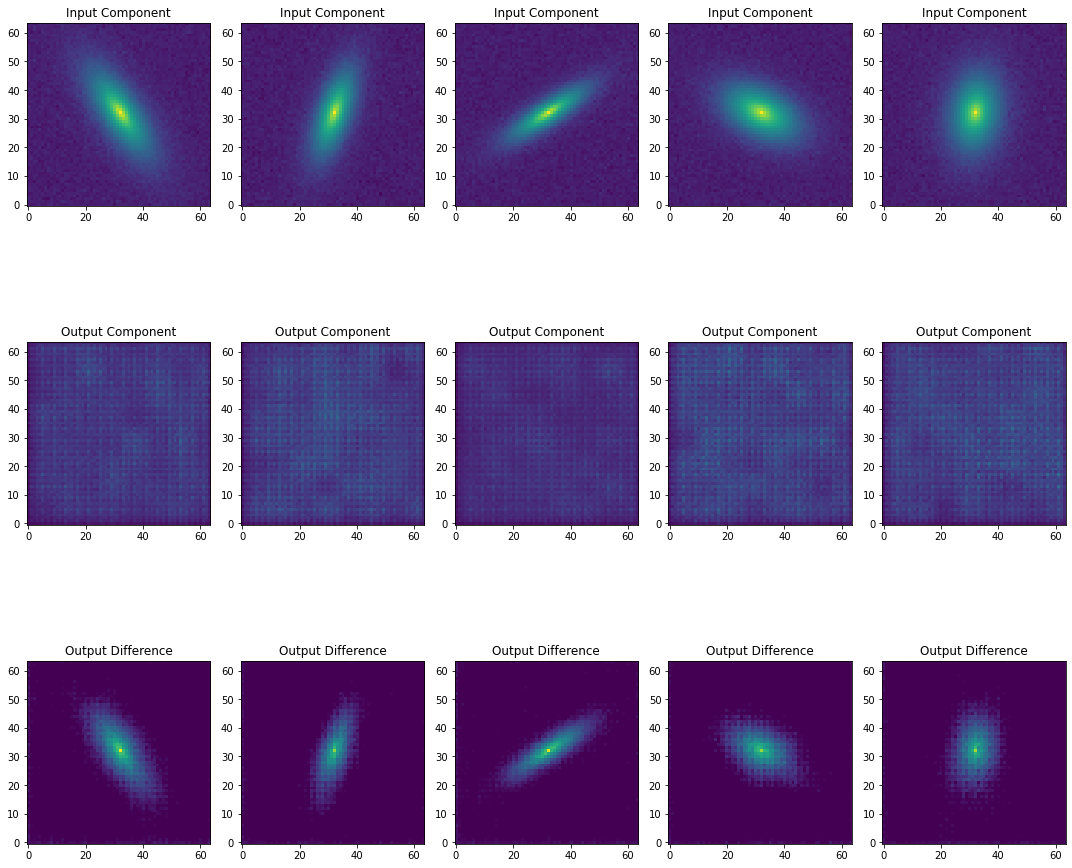

In [29]:
n=5
chosen=summary_plot(n,metrics_together[1],decode)

In [38]:


#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])



In [39]:


encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_5[0][0]']               
                                                                                            

In [40]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae2=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 32)           281024      ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 1)    190849      ['model_6[0][0]']                
                                                                                            

In [41]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae2.add_loss(mse_loss)
vae2.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae2.add_loss(kl_loss)
vae2.add_metric(kl_loss,'kl_loss')


vae2.compile(optimizer = Adam())

In [42]:
history2=vae2.fit(train_together, verbose = 1, epochs = 100, batch_size = batch_size, validation_split = 0.2)

Epoch 1/2
7/7 [==============================] - 1s 129ms/step - loss: 28.9941 - mse_loss: 28.9893 - kl_loss: 0.0049 - val_loss: 24.5018 - val_mse_loss: 24.4726 - val_kl_loss: 0.0292
Epoch 2/2
7/7 [==============================] - 1s 104ms/step - loss: 22.7138 - mse_loss: 22.6325 - kl_loss: 0.0812 - val_loss: 21.2613 - val_mse_loss: 21.1630 - val_kl_loss: 0.0982


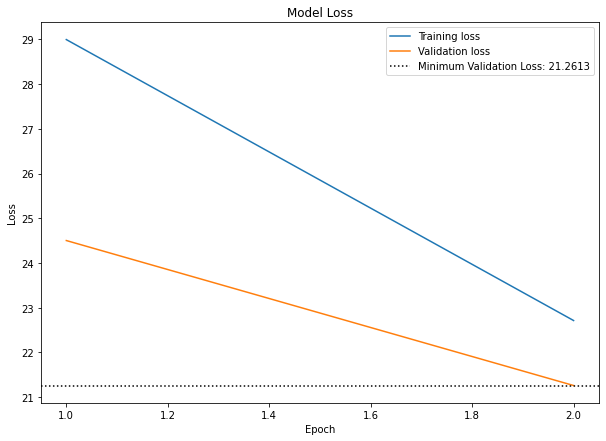

In [43]:
histplot(history2)

In [44]:
def summary_plot2(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Input Central Component')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[3, i].set_title('Output Central Component')
        ax[4, i].imshow(input_img[i] - output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[4, i].set_title('Output Residual Component')
        ax[5, i].imshow(abs(comp1[i] - output_img[i]), origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[5, i].set_title('Central Component Difference')
        plt.tight_layout()
    return idx


[39 41  2 48 50]


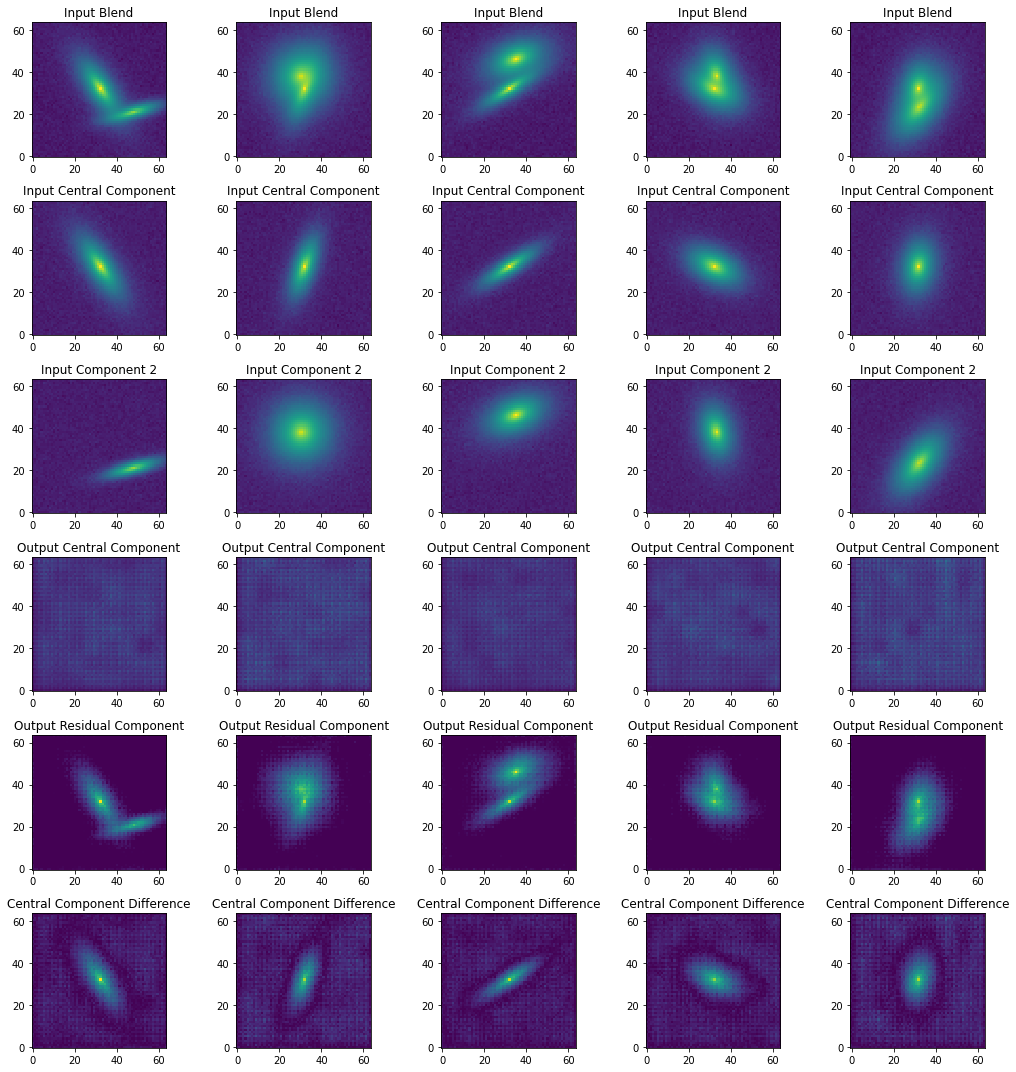

In [45]:
chosen=summary_plot2(n,metrics_together,decode)

In [50]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = ssim_comp1
    ssim_blends = ssim_comp1
    input_img = inputs[0]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1 = decode.predict([z])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], (input_img[i] - output_img1[i]), channel_axis = 2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2 ])
    
    return ssim_values 
        
        

    
    

In [51]:
ssim_values = calc_ssim(metrics_together, decode)


In [53]:
mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]

In [54]:
print(f' Mean SSIMs: Central Component: {mean_ssim_comp1:.4f}, Residual Component: {mean_ssim_comp2:.4f}')

print(f' Median SSIMs: Central Component: {median_ssim_comp1:.4f}, Residual Component: {median_ssim_comp2:.4f} ')


 Mean SSIMs: Central Component: -0.0743, Residual Component: -0.0743
 Median SSIMs: Central Component: -0.0605, Residual Component: -0.0605 


In [59]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    
    elip_in_comp1 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    
    flux_in_comp2 = np.zeros(test_ngals)
    
    flux_out_comp2 = np.zeros(test_ngals)
    
    elip_in_comp2 = np.zeros(test_ngals)

    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height, width)
    
    z = encode.predict(input_img)
    output_img1 = decode.predict([z])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
            
        out_comp2_cat = photutils.morphology.data_properties(input_img[i] - output_img1[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2]   
    return parameters


        

In [60]:
parameters = calc_properties(metrics_together, decode)

In [61]:

ellip_in_comp1 = parameters[0]
ellip_out_comp1 = parameters[1]
flux_in_comp1 = parameters[2]
flux_out_comp1 = parameters[3]
ellip_in_comp2 = parameters[4]
ellip_out_comp2 = parameters[5]
flux_in_comp2 = parameters[6]
flux_out_comp2 = parameters[7]



In [62]:
#Calculate the standard deviations 
def calc_std(parameters):
    num_of_params = len(parameters)
    standard_dev_of_params = np.zeros(num_of_params)
    for i in range(0,num_of_params):
        standard_dev_of_params[i] = np.std(parameters[i])
    return standard_dev_of_params



In [63]:
std_of_params = calc_std(parameters)


[3.28390883e-02 6.55763193e-03 1.09478876e+02 5.45006969e+01
 3.19700955e-02 1.44225270e-01 1.03634590e+02 1.20771976e+02]


In [69]:
print(f'Std dev of Ellip: Comp1 [In] {std_of_params[0]:.4f}, Comp1 [Out] {std_of_params[1]:.4f}, Comp2 [In] {std_of_params[4]:.4f}, Comp2 [Out] {std_of_params[5]:.4f} \n')
print(f'Std dev of Flux: Comp1 [In] {std_of_params[2]:.4f}, Comp1 [Out] {std_of_params[3]:.4f}, Comp2 [In] {std_of_params[6]:.4f}, Comp2 [Out] {std_of_params[7]:.4f}')

Std dev of Ellip: Comp1 [In] 0.0328, Comp1 [Out] 0.0066, Comp2 [In] 0.0320, Comp2 [Out] 0.1442 

Std dev of Flux: Comp1 [In] 109.4789, Comp1 [Out] 54.5007, Comp2 [In] 103.6346, Comp2 [Out] 120.7720


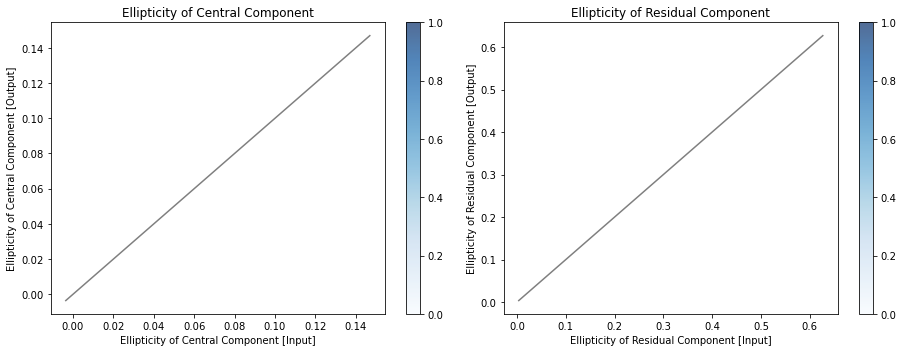

In [66]:

fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Ellipticity of Central Component")
hex1 = axes[0].hexbin(ellip_in_comp1, ellip_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Ellipticity of Central Component [Input]")
axes[0].set_ylabel("Ellipticity of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Ellipticity of Residual Component")
hex2 = axes[1].hexbin(ellip_in_comp2, ellip_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Ellipticity of Residual Component [Input]")
axes[1].set_ylabel("Ellipticity of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()


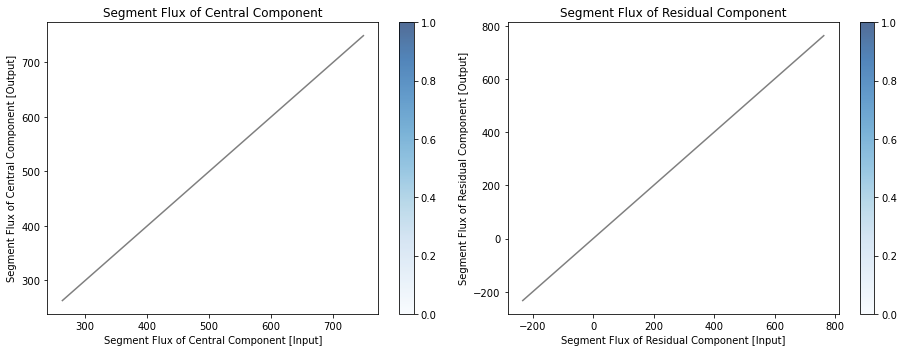

In [67]:
fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Segment Flux of Central Component")
hex1 = axes[0].hexbin(flux_in_comp1, flux_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Segment Flux of Central Component [Input]")
axes[0].set_ylabel("Segment Flux of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Segment Flux of Residual Component")
hex2 = axes[1].hexbin(flux_in_comp2, flux_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Segment Flux of Residual Component [Input]")
axes[1].set_ylabel("Segment Flux of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()

In [ ]:


# Calculate accuracys 

ellip_comp1_accuracy = abs(ellip_out_comp1 / ellip_in_comp1) * 100
mean_ellip_comp1_accuracy = np.mean(ellip_comp1_accuracy)
median_ellip_comp1_accuracy = np.median(ellip_comp1_accuracy)

flux_comp1_accuracy = abs(flux_out_comp1 / flux_in_comp1) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)

ellip_comp2_accuracy = abs(ellip_out_comp2 / ellip_in_comp2) * 100
mean_ellip_comp2_accuracy = np.mean(ellip_comp2_accuracy)
median_ellip_comp2_accuracy = np.median(ellip_comp2_accuracy)

flux_comp2_accuracy = abs(flux_out_comp2 / flux_in_comp2) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)




In [72]:
print(f' Mean ellipticity accuracys: Central Component: {mean_ellip_comp1_accuracy :.4f}, Residual Component: {mean_ellip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Central Component: {median_ellip_comp1_accuracy:.4f}, Residual Component: {median_ellip_comp2_accuracy:.4f} \n')
print(f' Mean flux accuracys: Central Component: {mean_flux_comp1_accuracy:.4f}, Residual Component: {mean_flux_comp2_accuracy}')
print(f' Median flux accuracys: Central Component: {median_flux_comp1_accuracy:.4f}, Residual Component: {median_flux_comp2_accuracy:.4f}')

 Mean ellipticity accuracys: Central Component: 34.1959, Residual Component: 481.3426
 Median ellipticity accuracys: Central Component: 20.3644, Residual Component: 421.7133 

 Mean flux accuracys: Central Component: 115.0217, Residual Component: 24.024309467296536
 Median flux accuracys: Central Component: 115.7467, Residual Component: 23.5306
